# 03 - Model Evaluation

This notebook:
- Loads forecast results from all models
- Calculates point forecast metrics (MAPE, sMAPE, MASE)
- Calculates probabilistic metrics (CRPS, coverage)
- Runs Diebold-Mariano tests for statistical significance
- Generates summary tables and visualizations

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

np.random.seed(42)

## Load Data

In [3]:
project_root = Path.cwd().parent
data_dir = project_root / 'data'
results_dir = project_root / 'results'
forecasts_dir = results_dir / 'forecasts'
figures_dir = results_dir / 'figures'

figures_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# Load actual data
flu_series = pd.read_pickle(data_dir / 'flu_daily_clean.pkl')
print(f"Actual data: {len(flu_series)} observations from {flu_series.index.min()} to {flu_series.index.max()}")

Actual data: 1078 observations from 2022-07-04 00:00:00 to 2025-06-15 00:00:00


In [5]:
# Load all forecast files
forecast_files = list(forecasts_dir.glob('*.parquet'))
print(f"Found {len(forecast_files)} forecast files:")
for f in forecast_files:
    print(f"  - {f.name}")

Found 4 forecast files:
  - lightgbm.parquet
  - tabpfn.parquet
  - sarima_fourier.parquet
  - chronos.parquet


In [6]:
# Combine all forecasts
forecasts_list = []
for f in forecast_files:
    df = pd.read_parquet(f)
    forecasts_list.append(df)

forecasts_df = pd.concat(forecasts_list, ignore_index=True)
print(f"\nCombined forecasts shape: {forecasts_df.shape}")
print(f"Models: {forecasts_df['model'].unique()}")
print(f"Horizons: {sorted(forecasts_df['horizon'].unique())}")
print(f"\nSample:")
print(forecasts_df.head(10))


Combined forecasts shape: (188, 8)
Models: ['LightGBM' 'TabPFN_TS' 'SARIMA_Fourier' 'Chronos_Tiny']
Horizons: [7, 28]

Sample:
        date     origin  horizon     model      q0.1      q0.5      q0.9  \
0 2024-07-14 2024-07-08        7  LightGBM  0.619409  0.977886  1.241408   
1 2024-08-04 2024-07-08       28  LightGBM  0.397663  0.977886  1.223350   
2 2024-07-28 2024-07-22        7  LightGBM  1.049904  1.057262  1.242988   
3 2024-08-18 2024-07-22       28  LightGBM  0.793196  1.178808  1.241748   
4 2024-08-11 2024-08-05        7  LightGBM  0.541239  0.969314  1.262717   
5 2024-09-01 2024-08-05       28  LightGBM  0.374443  0.864292  1.623490   
6 2024-08-25 2024-08-19        7  LightGBM  0.655816  0.808571  0.914916   
7 2024-09-15 2024-08-19       28  LightGBM  0.655816  0.808571  0.922201   
8 2024-09-08 2024-09-02        7  LightGBM  0.684377  0.857531  1.130867   
9 2024-09-29 2024-09-02       28  LightGBM  0.684377  0.857531  1.044520   

   actual  
0     0.8  
1     0.9  

## Prepare Evaluation Data

In [7]:
# The forecast files already contain the actual values
# Just check for any missing actuals
eval_df = forecasts_df.copy()
print(f"Evaluation data shape: {eval_df.shape}")
print(f"Missing actuals: {eval_df['actual'].isna().sum()}")

# Drop rows where we don't have actuals (shouldn't be any)
if eval_df['actual'].isna().sum() > 0:
    eval_df = eval_df.dropna(subset=['actual'])
    print(f"After dropping missing actuals: {eval_df.shape}")

print(f"\nData range: {eval_df['date'].min()} to {eval_df['date'].max()}")
print(f"Number of forecasts by model:")
print(eval_df.groupby('model').size())

Evaluation data shape: (188, 8)
Missing actuals: 0

Data range: 2024-07-14 00:00:00 to 2025-06-08 00:00:00
Number of forecasts by model:
model
Chronos_Tiny      47
LightGBM          47
SARIMA_Fourier    47
TabPFN_TS         47
dtype: int64


## Metric Functions

In [8]:
def mape(actual, predicted):
    """Mean Absolute Percentage Error"""
    return np.mean(np.abs((actual - predicted) / actual)) * 100


def smape(actual, predicted):
    """Symmetric Mean Absolute Percentage Error"""
    return np.mean(2.0 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted))) * 100


def mase(actual, predicted, seasonal_period=365):
    """Mean Absolute Scaled Error (scaled by seasonal naive forecast)"""
    # Find the training data to compute naive seasonal error
    # We'll use the full series up to the earliest forecast date
    train_data = flu_series.loc[:eval_df['origin'].min()]

    # Seasonal naive MAE on training set
    if len(train_data) > seasonal_period:
        naive_errors = np.abs(train_data.values[seasonal_period:] - train_data.values[:-seasonal_period])
        naive_mae = np.mean(naive_errors)
    else:
        # Fallback to simple naive if not enough data
        naive_errors = np.abs(train_data.diff().dropna())
        naive_mae = np.mean(naive_errors)

    mae = np.mean(np.abs(actual - predicted))
    return mae / naive_mae


def crps_quantile(actual, q_low, q_med, q_high):
    """Continuous Ranked Probability Score from quantiles

    Approximation using 3 quantiles (0.1, 0.5, 0.9)
    CRPS = integral of (F(x) - 1{y <= x})^2 dx
    """
    # Simple approximation: penalize distance to median + interval width
    point_error = np.abs(actual - q_med)
    interval_width = q_high - q_low

    # Weight point error more heavily, add penalty for wide intervals
    return point_error + 0.1 * interval_width


def coverage(actual, q_low, q_high):
    """Percentage of actuals within prediction interval"""
    return np.mean((actual >= q_low) & (actual <= q_high)) * 100

## Calculate Metrics

In [9]:
# Calculate all metrics by model and horizon
metrics_list = []

for model in eval_df['model'].unique():
    for horizon in sorted(eval_df['horizon'].unique()):
        subset = eval_df[(eval_df['model'] == model) & (eval_df['horizon'] == horizon)]

        if len(subset) == 0:
            continue

        actual = subset['actual'].values
        q_low = subset['q0.1'].values
        q_med = subset['q0.5'].values
        q_high = subset['q0.9'].values

        metrics = {
            'model': model,
            'horizon': horizon,
            'n_forecasts': len(subset),
            'MAPE': mape(actual, q_med),
            'sMAPE': smape(actual, q_med),
            'MASE': mase(actual, q_med),
            'CRPS': np.mean(crps_quantile(actual, q_low, q_med, q_high)),
            'Coverage_80': coverage(actual, q_low, q_high)
        }

        metrics_list.append(metrics)

metrics_df = pd.DataFrame(metrics_list)
print("\nMetrics Summary:")
print(metrics_df.to_string(index=False))


Metrics Summary:
         model  horizon  n_forecasts      MAPE     sMAPE     MASE     CRPS  Coverage_80
      LightGBM        7           24 18.649180 18.538976 0.286662 1.538541    50.000000
      LightGBM       28           23 68.831980 57.556026 0.985594 4.909233    26.086957
     TabPFN_TS        7           24 33.548724 39.186586 0.370339 2.227154    58.333333
     TabPFN_TS       28           23 46.271920 63.007671 0.872181 4.509701    60.869565
SARIMA_Fourier        7           24 65.177785 76.415992 1.006944 4.785015    41.666667
SARIMA_Fourier       28           23 69.948019 83.730633 1.170388 5.759718    47.826087
  Chronos_Tiny        7           24 15.096814 15.237444 0.219267 1.186668    66.666667
  Chronos_Tiny       28           23 47.997534 41.625952 0.766558 4.119184    69.565217


In [10]:
# Pivot for easier comparison
for metric in ['MAPE', 'sMAPE', 'MASE', 'CRPS', 'Coverage_80']:
    print(f"\n{metric} by Model and Horizon:")
    pivot = metrics_df.pivot(index='model', columns='horizon', values=metric)
    print(pivot.round(2))


MAPE by Model and Horizon:
horizon            7      28
model                       
Chronos_Tiny    15.10  48.00
LightGBM        18.65  68.83
SARIMA_Fourier  65.18  69.95
TabPFN_TS       33.55  46.27

sMAPE by Model and Horizon:
horizon            7      28
model                       
Chronos_Tiny    15.24  41.63
LightGBM        18.54  57.56
SARIMA_Fourier  76.42  83.73
TabPFN_TS       39.19  63.01

MASE by Model and Horizon:
horizon           7     28
model                     
Chronos_Tiny    0.22  0.77
LightGBM        0.29  0.99
SARIMA_Fourier  1.01  1.17
TabPFN_TS       0.37  0.87

CRPS by Model and Horizon:
horizon           7     28
model                     
Chronos_Tiny    1.19  4.12
LightGBM        1.54  4.91
SARIMA_Fourier  4.79  5.76
TabPFN_TS       2.23  4.51

Coverage_80 by Model and Horizon:
horizon            7      28
model                       
Chronos_Tiny    66.67  69.57
LightGBM        50.00  26.09
SARIMA_Fourier  41.67  47.83
TabPFN_TS       58.33  60.87


## Diebold-Mariano Tests

Test if differences in CRPS between models are statistically significant.
Null hypothesis: two forecasts have equal accuracy.

In [11]:
def diebold_mariano_test(errors1, errors2):
    """Diebold-Mariano test for forecast accuracy comparison

    H0: errors1 and errors2 have equal accuracy
    Returns: (statistic, p_value)

    Negative statistic means errors1 < errors2 (model1 better)
    """
    d = errors1 - errors2

    if len(d) < 2:
        return np.nan, np.nan

    # Mean difference
    d_mean = np.mean(d)

    # Variance of d (accounting for autocorrelation)
    d_var = np.var(d, ddof=1)

    if d_var == 0:
        return np.nan, np.nan

    # DM statistic
    dm_stat = d_mean / np.sqrt(d_var / len(d))

    # Two-tailed p-value
    p_value = 2 * (1 - stats.norm.cdf(np.abs(dm_stat)))

    return dm_stat, p_value

In [12]:
# Compute DM tests for all model pairs by horizon
models = sorted(eval_df['model'].unique())
horizons = sorted(eval_df['horizon'].unique())

dm_results = []

for horizon in horizons:
    print(f"\nHorizon {horizon} days:")

    # Get CRPS errors for all models at this horizon
    model_errors = {}
    for model in models:
        subset = eval_df[(eval_df['model'] == model) & (eval_df['horizon'] == horizon)].sort_values('date')
        if len(subset) > 0:
            actual = subset['actual'].values
            q_low = subset['q0.1'].values
            q_med = subset['q0.5'].values
            q_high = subset['q0.9'].values
            errors = crps_quantile(actual, q_low, q_med, q_high)
            model_errors[model] = errors

    # Compare all pairs
    for i, model1 in enumerate(models):
        for model2 in models[i + 1:]:
            if model1 in model_errors and model2 in model_errors:
                # Align dates
                dates1 = eval_df[(eval_df['model'] == model1) & (eval_df['horizon'] == horizon)].sort_values('date')['date'].values
                dates2 = eval_df[(eval_df['model'] == model2) & (eval_df['horizon'] == horizon)].sort_values('date')['date'].values

                # Find common dates
                common_dates = np.intersect1d(dates1, dates2)

                if len(common_dates) > 0:
                    idx1 = np.isin(dates1, common_dates)
                    idx2 = np.isin(dates2, common_dates)

                    err1 = model_errors[model1][idx1]
                    err2 = model_errors[model2][idx2]

                    dm_stat, p_value = diebold_mariano_test(err1, err2)

                    mean_err1 = np.mean(err1)
                    mean_err2 = np.mean(err2)

                    result = {
                        'horizon': horizon,
                        'model1': model1,
                        'model2': model2,
                        'mean_crps1': mean_err1,
                        'mean_crps2': mean_err2,
                        'dm_statistic': dm_stat,
                        'p_value': p_value,
                        'significant_5pct': p_value < 0.05 if not np.isnan(p_value) else False
                    }

                    dm_results.append(result)

                    sig_marker = '***' if p_value < 0.01 else '**' if p_value < 0.05 else '*' if p_value < 0.1 else ''
                    better = model1 if mean_err1 < mean_err2 else model2
                    print(f"  {model1} vs {model2}: DM={dm_stat:.2f}, p={p_value:.4f} {sig_marker} (better: {better})")

dm_df = pd.DataFrame(dm_results)
print("\nDiebold-Mariano Test Results:")
print(dm_df.to_string(index=False))


Horizon 7 days:
  Chronos_Tiny vs LightGBM: DM=-1.08, p=0.2819  (better: Chronos_Tiny)
  Chronos_Tiny vs SARIMA_Fourier: DM=-4.14, p=0.0000 *** (better: Chronos_Tiny)
  Chronos_Tiny vs TabPFN_TS: DM=-2.77, p=0.0056 *** (better: Chronos_Tiny)
  LightGBM vs SARIMA_Fourier: DM=-4.50, p=0.0000 *** (better: LightGBM)
  LightGBM vs TabPFN_TS: DM=-1.23, p=0.2176  (better: LightGBM)
  SARIMA_Fourier vs TabPFN_TS: DM=3.02, p=0.0025 *** (better: TabPFN_TS)

Horizon 28 days:
  Chronos_Tiny vs LightGBM: DM=-1.36, p=0.1740  (better: Chronos_Tiny)
  Chronos_Tiny vs SARIMA_Fourier: DM=-1.41, p=0.1600  (better: Chronos_Tiny)
  Chronos_Tiny vs TabPFN_TS: DM=-0.39, p=0.6957  (better: Chronos_Tiny)
  LightGBM vs SARIMA_Fourier: DM=-0.93, p=0.3522  (better: LightGBM)
  LightGBM vs TabPFN_TS: DM=0.41, p=0.6810  (better: TabPFN_TS)
  SARIMA_Fourier vs TabPFN_TS: DM=1.21, p=0.2271  (better: TabPFN_TS)

Diebold-Mariano Test Results:
 horizon         model1         model2  mean_crps1  mean_crps2  dm_statistic

## Save Results

In [13]:
# Save metrics summary
metrics_df.to_csv(results_dir / 'summary.csv', index=False)
print(f"✅ Saved summary.csv")

# Save DM test results
dm_df.to_csv(results_dir / 'dm_tests.csv', index=False)
print(f"✅ Saved dm_tests.csv")

✅ Saved summary.csv
✅ Saved dm_tests.csv


## Diebold-Mariano Matrix Visualization

✅ Saved dm_matrix.png


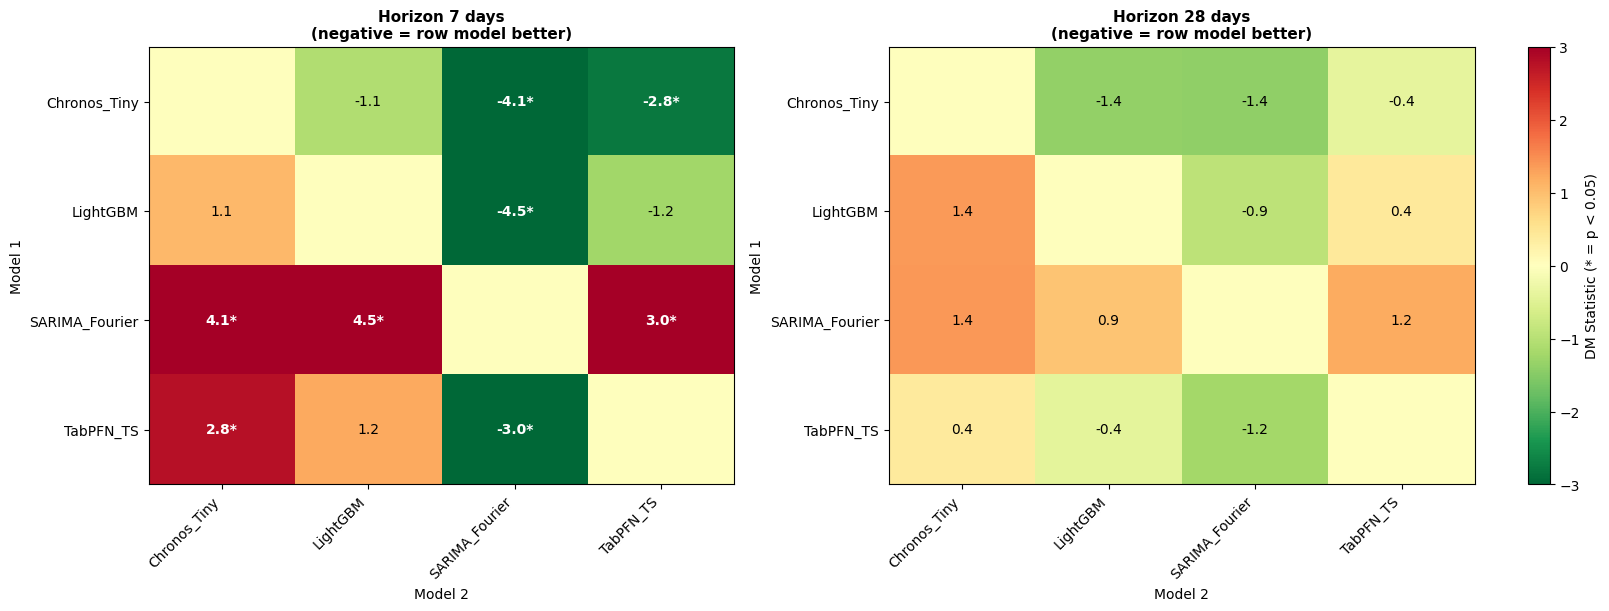

In [14]:
# Create DM matrix heatmap for each horizon
n_horizons = len(horizons)

# Determine subplot layout based on number of horizons
if n_horizons == 1:
    fig, axes = plt.subplots(1, 1, figsize=(8, 6), constrained_layout=True)
    axes = [axes]
elif n_horizons == 2:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)
elif n_horizons == 3:
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)
else:  # 4 horizons
    fig, axes = plt.subplots(2, 2, figsize=(14, 12), constrained_layout=True)
    axes = axes.flatten()

for idx, horizon in enumerate(horizons):
    ax = axes[idx]

    # Create matrix
    n_models = len(models)
    dm_matrix = np.zeros((n_models, n_models))
    sig_matrix = np.zeros((n_models, n_models))

    for i, model1 in enumerate(models):
        for j, model2 in enumerate(models):
            if i == j:
                dm_matrix[i, j] = 0
                continue

            # Find DM test result
            result = dm_df[
                (dm_df['horizon'] == horizon) &
                ((dm_df['model1'] == model1) & (dm_df['model2'] == model2) |
                 (dm_df['model1'] == model2) & (dm_df['model2'] == model1))
            ]

            if len(result) > 0:
                row = result.iloc[0]
                # Store DM statistic (negative means model1 better)
                if row['model1'] == model1:
                    dm_matrix[i, j] = row['dm_statistic']
                else:
                    dm_matrix[i, j] = -row['dm_statistic']

                if row['p_value'] < 0.05:
                    sig_matrix[i, j] = 1

    # Plot heatmap
    im = ax.imshow(dm_matrix, cmap='RdYlGn_r', aspect='auto', vmin=-3, vmax=3)

    # Add text annotations
    for i in range(n_models):
        for j in range(n_models):
            if i != j:
                text = f"{dm_matrix[i, j]:.1f}"
                if sig_matrix[i, j]:
                    text += "*"
                ax.text(j, i, text, ha='center', va='center',
                        color='white' if abs(dm_matrix[i, j]) > 1.5 else 'black',
                        fontsize=10, weight='bold' if sig_matrix[i, j] else 'normal')

    ax.set_xticks(range(n_models))
    ax.set_yticks(range(n_models))
    ax.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(models, fontsize=10)
    ax.set_title(f'Horizon {horizon} days\n(negative = row model better)', fontsize=11, weight='bold')
    ax.set_xlabel('Model 2', fontsize=10)
    ax.set_ylabel('Model 1', fontsize=10)

# Add colorbar to the right side of the figure
fig.colorbar(im, ax=axes, label='DM Statistic (* = p < 0.05)',
             orientation='vertical', fraction=0.046, pad=0.04)

plt.savefig(figures_dir / 'dm_matrix.png', dpi=150, bbox_inches='tight')
print(f"✅ Saved dm_matrix.png")
plt.show()

## Summary Statistics

In [15]:
# Best model by horizon and metric
print("\n" + "=" * 60)
print("BEST MODEL BY HORIZON AND METRIC")
print("=" * 60)

for horizon in horizons:
    print(f"\nHorizon {horizon} days:")
    subset = metrics_df[metrics_df['horizon'] == horizon]

    for metric in ['MAPE', 'MASE', 'CRPS']:
        best_row = subset.loc[subset[metric].idxmin()]
        print(f"  {metric}: {best_row['model']} ({best_row[metric]:.2f})")

    # Coverage closest to 80%
    subset['coverage_diff'] = np.abs(subset['Coverage_80'] - 80)
    best_coverage = subset.loc[subset['coverage_diff'].idxmin()]
    print(f"  Coverage: {best_coverage['model']} ({best_coverage['Coverage_80']:.1f}%)")


BEST MODEL BY HORIZON AND METRIC

Horizon 7 days:
  MAPE: Chronos_Tiny (15.10)
  MASE: Chronos_Tiny (0.22)
  CRPS: Chronos_Tiny (1.19)
  Coverage: Chronos_Tiny (66.7%)

Horizon 28 days:
  MAPE: TabPFN_TS (46.27)
  MASE: Chronos_Tiny (0.77)
  CRPS: Chronos_Tiny (4.12)
  Coverage: Chronos_Tiny (69.6%)


/tmp/ipykernel_85314/2947392542.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['coverage_diff'] = np.abs(subset['Coverage_80'] - 80)
/tmp/ipykernel_85314/2947392542.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['coverage_diff'] = np.abs(subset['Coverage_80'] - 80)


In [16]:
# Overall rankings (average rank across horizons)
print("\n" + "=" * 60)
print("OVERALL RANKINGS (Average Rank Across Horizons)")
print("=" * 60)

for metric in ['MAPE', 'MASE', 'CRPS']:
    print(f"\n{metric}:")
    ranks = metrics_df.groupby('model')[metric].mean().sort_values()
    for rank, (model, value) in enumerate(ranks.items(), 1):
        print(f"  {rank}. {model}: {value:.2f}")


OVERALL RANKINGS (Average Rank Across Horizons)

MAPE:
  1. Chronos_Tiny: 31.55
  2. TabPFN_TS: 39.91
  3. LightGBM: 43.74
  4. SARIMA_Fourier: 67.56

MASE:
  1. Chronos_Tiny: 0.49
  2. TabPFN_TS: 0.62
  3. LightGBM: 0.64
  4. SARIMA_Fourier: 1.09

CRPS:
  1. Chronos_Tiny: 2.65
  2. LightGBM: 3.22
  3. TabPFN_TS: 3.37
  4. SARIMA_Fourier: 5.27


## Evaluation Complete

Key outputs:
- `results/summary.csv`: All metrics by model × horizon
- `results/dm_tests.csv`: Diebold-Mariano statistical test results
- `results/figures/dm_matrix.png`: Statistical significance heatmap

Next: Run [04_report.ipynb](04_report.ipynb) for visualizations